In [78]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cosine, minkowski
from matplotlib import pyplot as plt
import optuna
from optuna.samplers import TPESampler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

import warnings
warnings.filterwarnings('ignore')

In [100]:
df = pd.read_csv('train.csv')
X = df.drop(columns=['price_range'])
y = df['price_range']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
print(df.head())


   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2       0.0   1       0           7    0.6   
1           1021     1          0.5       1.0   0       1          53    0.7   
2            563     1          0.5       1.0   2       1          41    0.9   
3            615     1          2.5       0.0   0       0          10    0.8   
4           1821     1          1.2       0.0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0      188.0        2  ...         20       756  2549     9     7         19   
1      136.0        3  ...        905      1988  2631    17     3          7   
2      145.0        5  ...       1263      1716  2603    11     2          9   
3      131.0        6  ...       1216      1786  2769    16     8         11   
4      141.0        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  price_

In [80]:
def cosine_distance(u, v):
    return cosine(u, v)

def minkowski_distance(u, v, p=2):
    return minkowski(u, v, p)

def uniform_kernel(distances):
    return np.ones_like(distances)

def gaussian_kernel(distances, sigma=1.0):
    return np.exp(-distances ** 2 / (2 * sigma ** 2))

def custom_kernel(distances, a=2, b=2):
    return (1 - np.abs(distances) ** a) ** b


In [72]:
class CustomKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean', kernel=uniform_kernel, p=2, sigma=1.0, a=2, b=2):
        self.y_train_ = None
        self.X_train_ = None
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.kernel = kernel
        self.p = p
        self.sigma = sigma
        self.a = a
        self.b = b

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_train_ = X
        self.y_train_ = y
        return self

    def predict(self, X):
        X = check_array(X)
        check_is_fitted(self)

        y_pred = []
        for x in X:
            distances = []
            dist = 0.0
            for x_train in self.X_train_:
                if self.metric == 'euclidean':
                    dist = np.linalg.norm(x - x_train)
                elif self.metric == 'cosine':
                    dist = cosine_distance(x, x_train)
                elif self.metric == 'minkowski':
                    dist = minkowski_distance(x, x_train, self.p)
                distances.append(dist)
            distances = np.array(distances)
            kernel_weights = self.kernel(distances)
            idx = np.argsort(distances)[:self.n_neighbors]
            y_pred.append(np.bincount(self.y_train_[idx], weights=kernel_weights[idx]).argmax())
        return np.array(y_pred)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

In [73]:
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    metric = trial.suggest_categorical('metric', ['euclidean', 'cosine', 'minkowski'])
    kernel = trial.suggest_categorical('kernel', ['uniform', 'gaussian', 'custom'])
    p = trial.suggest_int('p', 1, 5)
    sigma = trial.suggest_float('sigma', 0.1, 10.0)
    a = trial.suggest_int('a', 1, 5)
    b = trial.suggest_int('b', 1, 5)

    if kernel == 'uniform':
        kernel_function = uniform_kernel
    elif kernel == 'gaussian':
        kernel_function = lambda distance: gaussian_kernel(distance, sigma)
    elif kernel == 'custom':
        kernel_function = lambda distance: custom_kernel(distance, a, b)

    model = CustomKNeighborsClassifier(
        n_neighbors=n_neighbors, 
        metric=metric, 
        kernel=kernel_function, 
        p=p, 
        sigma=sigma, 
        a=a, 
        b=b
    )
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=5)

best_params = study.best_params
print("Лучшие гиперпараметры:", best_params)

kernel_function = uniform_kernel
if best_params['kernel'] == 'gaussian':
    kernel_function = lambda distance: gaussian_kernel(distance, best_params['sigma'])
elif best_params['kernel'] == 'custom':
    kernel_function = lambda distance: custom_kernel(distance, best_params['a'], best_params['b'])

best_model = CustomKNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    metric=best_params['metric'],
    kernel=kernel_function,
    p=best_params['p'],
    sigma=best_params['sigma'],
    a=best_params['a'],
    b=best_params['b']
)
best_model.fit(X_train, y_train)
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print(f"Тренировочная точность: {train_score}")
print(f"Тестовая точность: {test_score}")

from sklearn.neighbors import KNeighborsClassifier

def objective_sklearn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    p = trial.suggest_int('p', 1, 5)

    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, p=p)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

study_sklearn = optuna.create_study(direction='maximize', sampler=TPESampler())
study_sklearn.optimize(objective_sklearn, n_trials=5)

best_params_sklearn = study_sklearn.best_params
print("Лучшие гиперпараметры для sklearn KNN:", best_params_sklearn)

model_sklearn_best = KNeighborsClassifier(
    n_neighbors=best_params_sklearn['n_neighbors'],
    metric=best_params_sklearn['metric'],
    p=best_params_sklearn['p']
)
model_sklearn_best.fit(X_train, y_train)
train_score_sklearn = model_sklearn_best.score(X_train, y_train)
test_score_sklearn = model_sklearn_best.score(X_test, y_test)

print(f"Тренировочная точность (sklearn): {train_score_sklearn}")
print(f"Тестовая точность (sklearn): {test_score_sklearn}")

Лучшие гиперпараметры: {'n_neighbors': 20, 'metric': 'minkowski', 'kernel': 'uniform', 'p': 2, 'sigma': 6.627773200211224, 'a': 4, 'b': 4}
Тренировочная точность: 0.7
Тестовая точность: 0.615
Лучшие гиперпараметры для sklearn KNN: {'n_neighbors': 20, 'metric': 'manhattan', 'p': 3}
Тренировочная точность (sklearn): 0.7245833333333334
Тестовая точность (sklearn): 0.6466666666666666


Лучшие гиперпараметры: {'n_neighbors': 14, 'metric': 'euclidean', 'kernel': 'uniform', 'p': 3, 'sigma': 8.504152100354533, 'a': 4, 'b': 5}


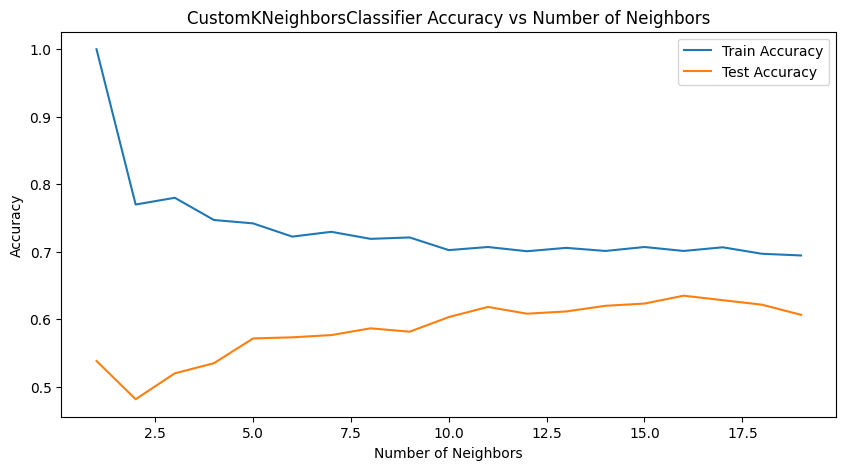

Лучшие гиперпараметры для sklearn: {'n_neighbors': 20, 'metric': 'manhattan', 'p': 3}


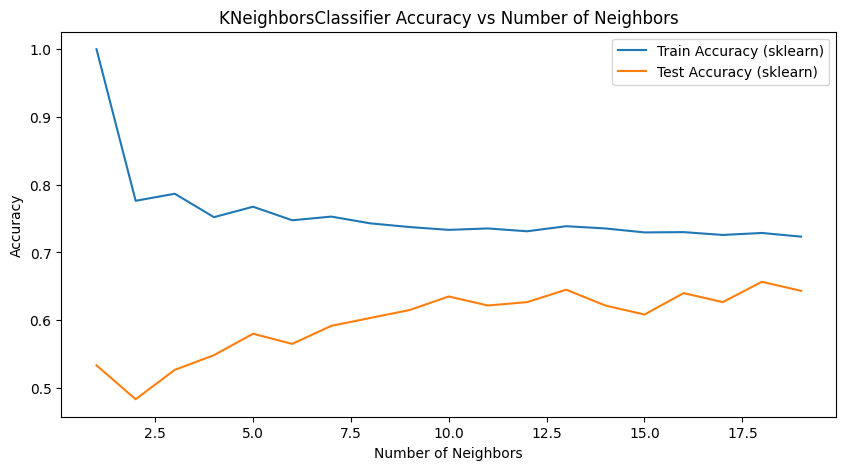

In [74]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=5)

best_params = study.best_params
print("Лучшие гиперпараметры:", best_params)

kernel_function = uniform_kernel
if best_params['kernel'] == 'gaussian':
    kernel_function = lambda distances: gaussian_kernel(distances, best_params['sigma'])
elif best_params['kernel'] == 'custom':
    kernel_function = lambda distances: custom_kernel(distances, best_params['a'], best_params['b'])

metric = best_params['metric']
kernel = kernel_function
p = best_params['p']
sigma = best_params['sigma']
a = best_params['a']
b = best_params['b']

train_scores = []
test_scores = []
neighbors_range = range(1, 20)

for n_neighbors in neighbors_range:
    model = CustomKNeighborsClassifier(
        n_neighbors=n_neighbors,
        metric=metric,
        kernel=kernel,
        p=p,
        sigma=sigma,
        a=a,
        b=b
    )
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(neighbors_range, train_scores, label='Train Accuracy')
plt.plot(neighbors_range, test_scores, label='Test Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('CustomKNeighborsClassifier Accuracy vs Number of Neighbors')
plt.legend()
plt.show()

study_sklearn.optimize(objective_sklearn, n_trials=5)
best_params_sklearn = study_sklearn.best_params
print("Лучшие гиперпараметры для sklearn:", best_params_sklearn)

metric = best_params_sklearn['metric']
p = best_params_sklearn['p']

train_scores_sklearn = []
test_scores_sklearn = []

for n_neighbors in neighbors_range:
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        metric=metric,
        p=p
    )
    model.fit(X_train, y_train)
    train_scores_sklearn.append(model.score(X_train, y_train))
    test_scores_sklearn.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(neighbors_range, train_scores_sklearn, label='Train Accuracy (sklearn)')
plt.plot(neighbors_range, test_scores_sklearn, label='Test Accuracy (sklearn)')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('KNeighborsClassifier Accuracy vs Number of Neighbors')
plt.legend()
plt.show()

In [129]:
from sklearn.utils import resample


def lowess_anomaly_detection(X_train, y_train, X_test, y_test, model):
    y_train_pred = model.predict(X_train)

    residuals = np.abs(y_train - y_train_pred)
    anomaly_indices = np.where(residuals > 0.05)[0]
    return anomaly_indices

def weight_instances(X_train, y_train, anomaly_indices):
    weights = np.ones(len(X_train))
    weights[anomaly_indices] = 0.5
    return weights

best_params = study.best_params
n_neighbors = best_params['n_neighbors']
metric = best_params['metric']
kernel = kernel_function
p = best_params['p']
sigma = best_params['sigma']
a = best_params['a']
b = best_params['b']

custom_knn = CustomKNeighborsClassifier(
        n_neighbors=n_neighbors, 
        metric=metric, 
        kernel=kernel_function, 
        p=p, 
        sigma=sigma, 
        a=a, 
        b=b)
custom_knn.fit(X_train, y_train)

print('Accuracy without weighting:', custom_knn.score(X_test, y_test))

sample_indices = lowess_anomaly_detection(X_train, y_train, X_test, y_test, custom_knn)
weighted_indices = resample(sample_indices, replace=True, n_samples=len(X_train), random_state=1488)
X_train_weighted, y_train_weighted = X_train[weighted_indices], y_train[weighted_indices]
custom_knn.fit(X_train_weighted, y_train_weighted)
accuracy = custom_knn.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy without weighting: 0.62
Accuracy: 0.44


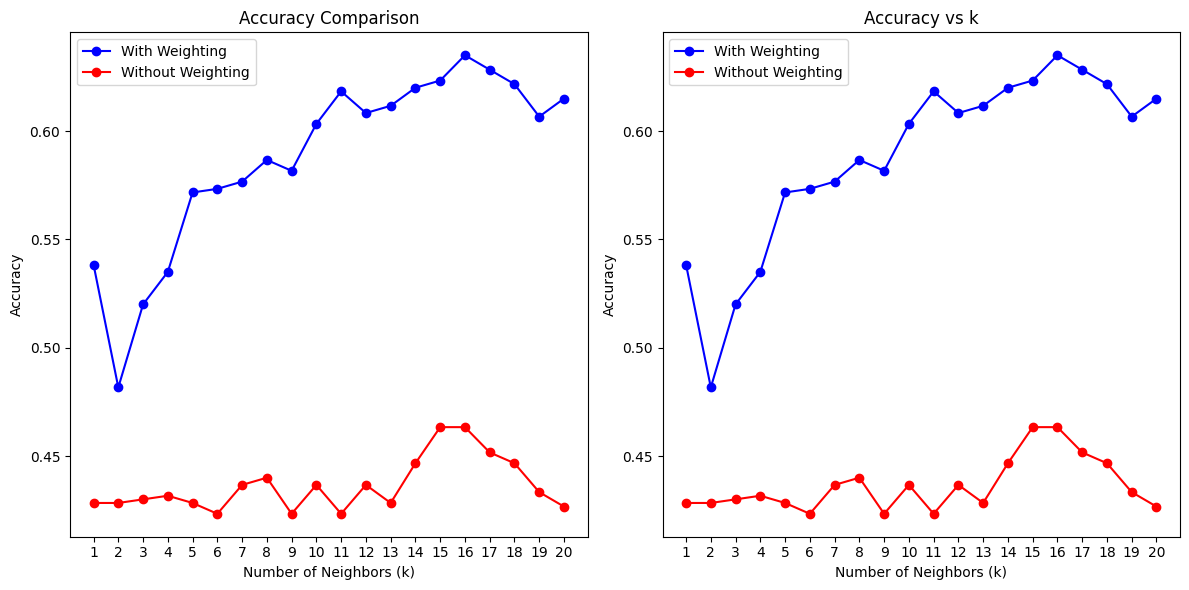

In [131]:
k_values = list(range(1, 21))
accuracy_no_weighting = []
accuracy_with_weighting = []

for k in k_values:
    knn_no_weighting = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='uniform')
    knn_no_weighting.fit(X_train, y_train)
    accuracy_no_weighting.append(knn_no_weighting.score(X_test, y_test))

    knn_with_weighting = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='distance')
    knn_with_weighting.fit(X_train_weighted, y_train_weighted)
    accuracy_with_weighting.append(knn_with_weighting.score(X_test, y_test))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, accuracy_no_weighting, marker='o', linestyle='-', color='b', label='With Weighting')
plt.plot(k_values, accuracy_with_weighting, marker='o', linestyle='-', color='r', label='Without Weighting')
plt.title('Accuracy Comparison')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(k_values, accuracy_no_weighting, marker='o', linestyle='-', color='b', label='With Weighting')
plt.plot(k_values, accuracy_with_weighting, marker='o', linestyle='-', color='r', label='Without Weighting')
plt.title('Accuracy vs k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()

plt.tight_layout()
plt.show()